In [1]:
from KeyFunctions.TheoryFunctions import *
from KeyFunctions.SimulationFunctions import *

from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.pyplot as plt
import matplotlib.cm as cm

# Default parameters

In [2]:
# Strength and structure of noise
sigE=1; sigI=1; c=0

# 'Diffusion' matrix for the noise term
D_private = np.diag([np.sqrt(1-c)*sigE, np.sqrt(1-c)*sigE, sigI, sigI])
D_shared = np.array([np.sqrt(c)*sigE,np.sqrt(c)*sigE,0, 0])
DMatrix = np.c_[D_private,D_shared]

# Time constants
tau_E=15; tau_I=15
tau = np.array([[tau_E], [tau_E], [tau_I], [tau_I]])

# Connectivity parameters
Wee = 1.15; alpha = 0.15
Wii=0.5
Wei=0.8; Wie=0.8
beta = 0; gamma = 0; zeta = 0
W = np.block([[Wee, alpha*Wee, -Wei, -beta*Wei],
              [alpha*Wee, Wee, -beta*Wei, -Wei],
              [Wie, gamma*Wie, -Wii, -zeta*Wii],
              [gamma*Wie, Wie, -zeta*Wii, -Wii]])

# Numerics
K = 200 # Discretize 2D parameter space

# Find the corrlation between E1 and E2 as a function of Wei and Wie (two-dimensional parameter sweep)

In [3]:
#range of W_EI
Wei_vec = np.linspace(0, 2, K)
Wie_vec = np.linspace(0, 2, K) 

Corrs_12 = np.zeros((K,K))
Covs_12 = np.zeros((K,K))
Max_evrp = np.zeros((K,K))

for i in range(K):
        Wei = Wei_vec[i]
        for j in range(K):
            Wie = Wie_vec[j]
            
            W[0,2] = -Wei # I->E
            W[1,3] = -Wei # I->E
            W[2,0] = Wie # E->I
            W[3,1] = Wie # E->I
            
            Cov, Corr, Max_evrp[i,j],_ = corrTheory(W, DMatrix)
            Covs_12[i,j] = Cov[0,1]
            Corrs_12[i,j] = Corr[0,1]

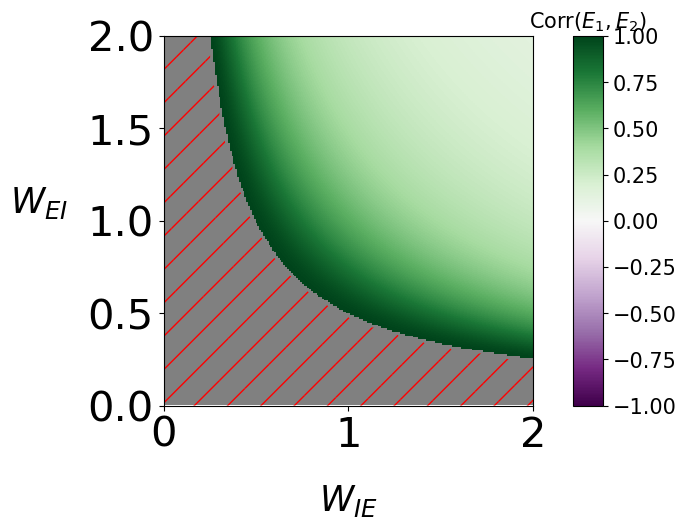

In [4]:
fig,ax = plt.subplots()
plt.rcParams.update({'hatch.color': 'red'})

cmap = cm.get_cmap("PRGn").copy()
cmap.set_bad(color='gray')

divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='8%', pad=.4)
im = ax.imshow(np.flip(Corrs_12, axis=0), cmap=cmap, vmin=-1, vmax= 1, extent=[0, 2, 0, 2])
cbar=fig.colorbar(im, cax=cax, orientation='vertical')

unstable_eigmask = np.ma.masked_less(Max_evrp,1) 
hatches = ax.contourf(Wei_vec, Wie_vec, unstable_eigmask, extent=[0, 2, 0, 2], hatches='//', alpha=0.)


ax.xaxis.set_tick_params(labelsize=30)
ax.yaxis.set_tick_params(labelsize=30)
ax.set_xlabel(r'$W_{IE}$', fontsize=25, labelpad=20)
ax.set_ylabel(r'$W_{EI}$', rotation=0, fontsize=25, labelpad=35)
cbar.ax.yaxis.set_tick_params(labelsize=15)

ax.set_xlim(0,2)
ax.set_ylim(0,2)
plt.title(r'Corr$(E_1,E_2)$', fontsize=15)

plt.show()

# Find the corrlation between E1 and E2 as a function of cross connections (e.g., E1->I1)

In [5]:
Wee = 1.15; alpha = 0.15; Wii=0.5; Wei=1; Wie=1
beta = 0; gamma = 0; zeta = 0
W = np.block([[Wee, alpha*Wee, -Wei, -beta*Wei],
              [alpha*Wee, Wee, -beta*Wei, -Wei],
              [Wie, gamma*Wie, -Wii, -zeta*Wii],
              [gamma*Wie, Wie, -zeta*Wii, -Wii]])


Corrs_12 = np.zeros((K,3))
PR = np.zeros((K,3))
PR2 = np.zeros((K,3))
crossConnection = np.linspace(0,1,K)

# Turning on cross I connections
for i in range(K):            
    W[2,3] = -crossConnection[i]*Wii # I->I
    W[3,2] = -crossConnection[i]*Wii # I->I

    Cov, Corr, _,_ = corrTheory(W, DMatrix)
    Corrs_12[i,0] = Corr[0,1]
    
    subMatrix = Cov[0:2,0:2]
    CovSquared = Cov@Cov
    subMatrixSquared = CovSquared[0:2,0:2]
    if ~np.isnan(Cov[0,0]):
        PR[i,0] = sum(np.linalg.eigvals(Cov))**2/sum(np.linalg.eigvals(Cov@Cov))
        PR2[i,0] = sum(np.linalg.eigvals(subMatrix))**2/sum(np.linalg.eigvals(subMatrixSquared))

W[2,3] = 0; W[3,2] = 0
# Turning on cross I->E connections
for i in range(K): 
    W[0,3] = -crossConnection[i]*Wei # I->E
    W[1,2] = -crossConnection[i]*Wei # I->E

    Cov, Corr, _,_ = corrTheory(W, DMatrix)
    Corrs_12[i,1] = Corr[0,1]
    
    subMatrix = Cov[0:2,0:2]
    CovSquared = Cov@Cov
    subMatrixSquared = CovSquared[0:2,0:2]
    if ~np.isnan(Cov[0,0]):
        PR[i,1] = sum(np.linalg.eigvals(Cov))**2/sum(np.linalg.eigvals(Cov@Cov))
        PR2[i,1] = sum(np.linalg.eigvals(subMatrix))**2/sum(np.linalg.eigvals(subMatrixSquared))
    
W[0,3] = 0; W[1,2] = 0
# Turning on cross E->I connections
for i in range(K): 
    W[2,1] = crossConnection[i]*Wie # E->I
    W[3,0] = crossConnection[i]*Wie # E->I

    Cov, Corr, _,_ = corrTheory(W, DMatrix)
    Corrs_12[i,2] = Corr[0,1]
    
    # Participation ratio calculation
    subMatrix = Cov[0:2,0:2]
    CovSquared = Cov@Cov
    subMatrixSquared = CovSquared[0:2,0:2]
    if ~np.isnan(Cov[0,0]):
        PR[i,2] = sum(np.linalg.eigvals(Cov))**2/sum(np.linalg.eigvals(Cov@Cov))
        PR2[i,2] = sum(np.linalg.eigvals(subMatrix))**2/sum(np.linalg.eigvals(subMatrixSquared))


## Corr plots has a function of cross-connection strength 

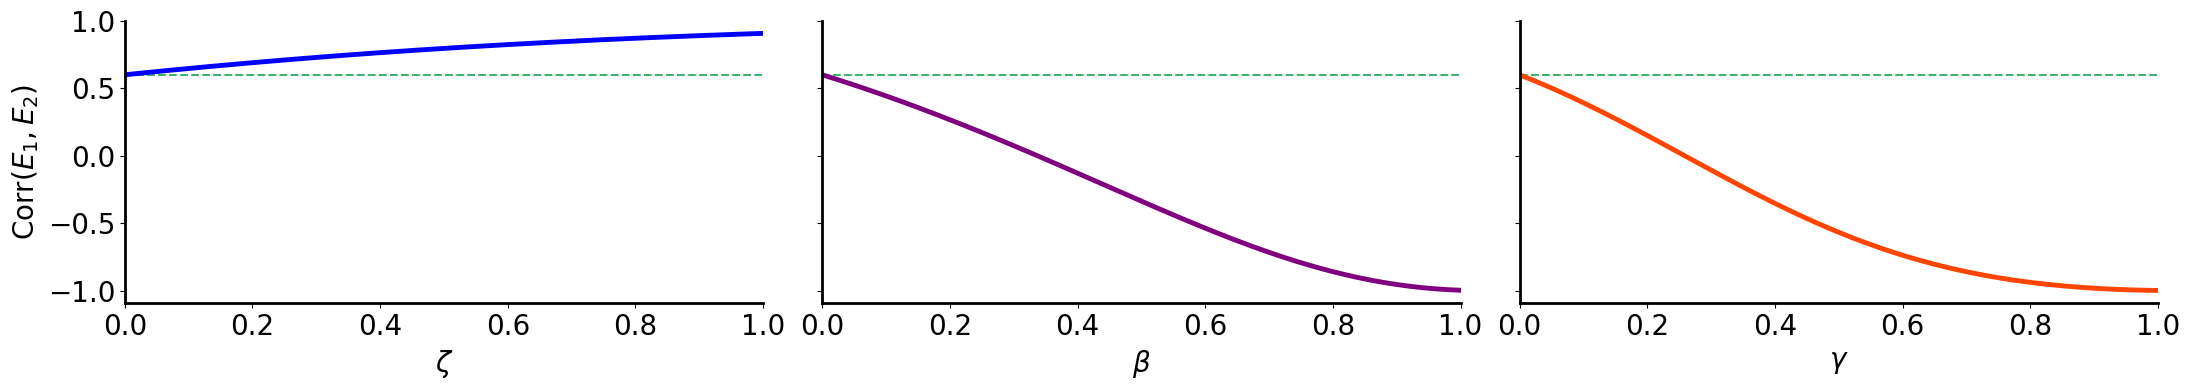

In [6]:
fig, axs = plt.subplots(figsize=(22,4),nrows=1, ncols=3, sharey=True)

for i in range(3):
    axs[i].spines.left.set_linewidth(2)
    axs[i].spines.bottom.set_linewidth(2)
    axs[i].spines.right.set_color('none')
    axs[i].spines.top.set_color('none')
    axs[i].xaxis.set_tick_params(labelsize=20)
    axs[i].yaxis.set_tick_params(labelsize=20)
    axs[i].set_xlim(0,1) 
    axs[i].axhline(y=Corrs_12[0,0], linestyle='--', color='mediumseagreen')

        
axs[0].plot(crossConnection, Corrs_12[:,0], linewidth=3.5, color='blue', label=r'$\zeta$')
axs[0].set_xlabel(r'$\zeta$', fontsize=20, labelpad=5)
axs[0].set_ylabel(r'Corr$(E_1,E_2)$', fontsize=20, labelpad=5)


axs[1].plot(crossConnection, Corrs_12[:,1], linewidth=3.5, color='purple', label=r'$\beta$')
axs[1].set_xlabel(r'$\beta$', fontsize=20, labelpad=5)
axs[1].set_xlim(0,1)

axs[2].plot(crossConnection, Corrs_12[:,2], linewidth=3.5, color='orangered', label=r'$\gamma$')
axs[2].set_xlabel(r'$\gamma$', fontsize=20, labelpad=5)
axs[2].set_xlim(0,1)
       
plt.tight_layout()
plt.show()       

## Participation ratio plots

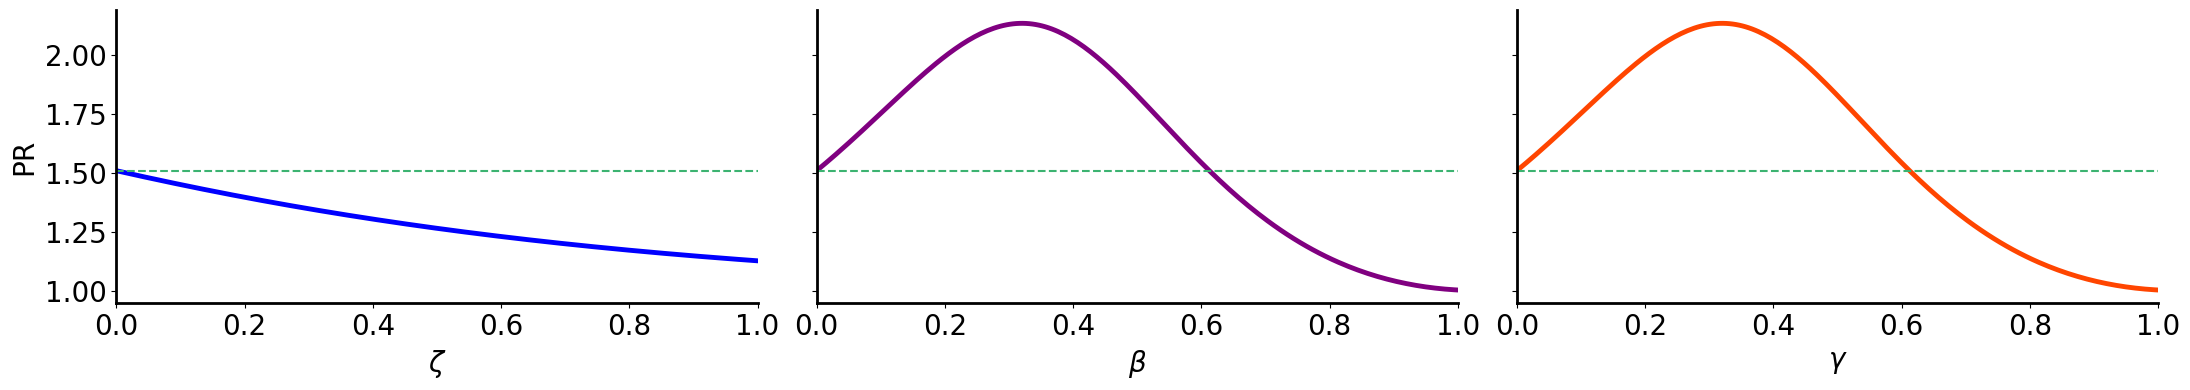

In [7]:
fig, axs = plt.subplots(figsize=(22,4),nrows=1, ncols=3, sharey=True)

colors = ['blue','purple','orangered']

for i in range(3):
    axs[i].spines.left.set_linewidth(2)
    axs[i].spines.bottom.set_linewidth(2)
    axs[i].spines.right.set_color('none')
    axs[i].spines.top.set_color('none')
    axs[i].xaxis.set_tick_params(labelsize=20)
    axs[i].yaxis.set_tick_params(labelsize=20)
    
    axs[i].plot(crossConnection, PR[:,i], linewidth=3.5, color=colors[i])
    axs[i].axhline(y=PR[0,0], linestyle='--', color='mediumseagreen')
    axs[i].set_xlim(0,1) 
    
axs[0].set_ylabel(r'PR', fontsize=20, labelpad=5)

axs[0].set_xlabel(r'$\zeta$', fontsize=20, labelpad=5)
axs[1].set_xlabel(r'$\beta$', fontsize=20, labelpad=5)
axs[2].set_xlabel(r'$\gamma$', fontsize=20, labelpad=5)


plt.tight_layout()
plt.show()  

# Now let's covary a few of the parameters

## Let's start with $\zeta$ and $\beta$

In [8]:
Wee = 1.15; alpha = 0.15; Wii=0.5; Wei=1; Wie=1
beta = 0; gamma = 0; zeta = 0
W = np.block([[Wee, alpha*Wee, -Wei, -beta*Wei],
              [alpha*Wee, Wee, -beta*Wei, -Wei],
              [Wie, gamma*Wie, -Wii, -zeta*Wii],
              [gamma*Wie, Wie, -zeta*Wii, -Wii]])

ratioVec = [0.25, 0.5, 1, 2]
Corrs_zb = np.zeros((K,np.shape(ratioVec)[0]))
crossConnection = np.linspace(0,1,K)
for i in range(K):   
    counter = 0
    for r in ratioVec:
        W[2,3] = -crossConnection[i]*Wii # I->I
        W[3,2] = -crossConnection[i]*Wii # I->I
        W[0,3] = -r*crossConnection[i]*Wei # I->E
        W[1,2] = -r*crossConnection[i]*Wei # I->E

        _, Corr,_,_ = corrTheory(W, DMatrix)
        Corrs_zb[i,counter] = Corr[0,1]
        counter = counter + 1
    

## Now do $\zeta$ and $\gamma$

In [9]:
Wee = 1.15; alpha = 0.15; Wii=0.5; Wei=1; Wie=1
beta = 0; gamma = 0; zeta = 0
W = np.block([[Wee, alpha*Wee, -Wei, -beta*Wei],
              [alpha*Wee, Wee, -beta*Wei, -Wei],
              [Wie, gamma*Wie, -Wii, -zeta*Wii],
              [gamma*Wie, Wie, -zeta*Wii, -Wii]])


ratioVec = [0.25, 0.5, 1, 2]
Corrs_zg = np.zeros((K,np.shape(ratioVec)[0]))
crossConnection = np.linspace(0,1,K)
for i in range(K):   
    counter = 0
    for r in ratioVec:
        W[2,3] = -crossConnection[i]*Wii # I->I
        W[3,2] = -crossConnection[i]*Wii # I->I
        W[2,1] = r*crossConnection[i]*Wie # E->I
        W[3,0] = r*crossConnection[i]*Wie # E->I

        _, Corr, _,_ = corrTheory(W, DMatrix)
        Corrs_zg[i,counter] = Corr[0,1]
        counter = counter + 1

## Finally, we end with $\beta$ and $\gamma$


In [10]:
Wee = 1.15; alpha = 0.15; Wii=0.5; Wei=1; Wie=1
beta = 0; gamma = 0; zeta = 0
W = np.block([[Wee, alpha*Wee, -Wei, -beta*Wei],
              [alpha*Wee, Wee, -beta*Wei, -Wei],
              [Wie, gamma*Wie, -Wii, -zeta*Wii],
              [gamma*Wie, Wie, -zeta*Wii, -Wii]])

ratioVec = [0.25, 0.5, 1, 2]
Corrs_bg = np.zeros((K,np.shape(ratioVec)[0]))
crossConnection = np.linspace(0,1,K)
for i in range(K):   
    counter = 0
    for r in ratioVec:
        W[0,3] = -crossConnection[i]*Wei # I->E
        W[1,2] = -crossConnection[i]*Wei # I->E
        W[2,1] = r*crossConnection[i]*Wie # E->I
        W[3,0] = r*crossConnection[i]*Wie # E->I

        _, Corr,_,_ = corrTheory(W, DMatrix)
        Corrs_bg[i,counter] = Corr[0,1]
        counter = counter + 1

## Now let's plot the results

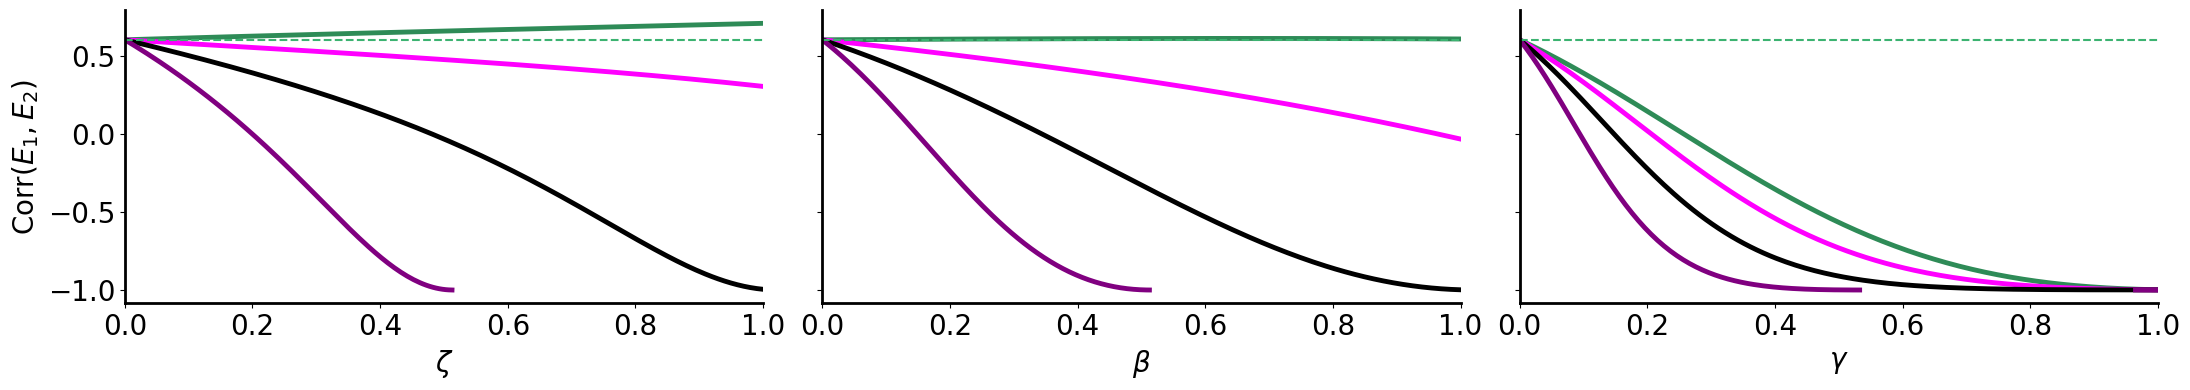

In [11]:
colors = ['seagreen','magenta','black','purple']

fig, axs = plt.subplots(figsize=(22,4),nrows=1, ncols=3, sharey=True)

for i in range(4):
    axs[0].plot(crossConnection, Corrs_zb[:,i], linewidth=3.5, color=colors[i])
    axs[1].plot(crossConnection, Corrs_zg[:,i], linewidth=3.5, color=colors[i])
    axs[2].plot(crossConnection, Corrs_bg[:,i], linewidth=3.5, color=colors[i])
    
for i in range(3):
    axs[i].spines.left.set_linewidth(2)
    axs[i].spines.bottom.set_linewidth(2)
    axs[i].spines.right.set_color('none')
    axs[i].spines.top.set_color('none')
    axs[i].xaxis.set_tick_params(labelsize=20)
    axs[i].yaxis.set_tick_params(labelsize=20)
    axs[i].set_xlim(0,1) 
    axs[i].axhline(y=Corrs_zb[0,0], linestyle='--', color='mediumseagreen')


axs[0].set_xlabel(r'$\zeta$', fontsize=20, labelpad=5)
axs[0].set_ylabel(r'Corr$(E_1,E_2)$', fontsize=20, labelpad=5)
axs[1].set_xlabel(r'$\beta$', fontsize=20, labelpad=5)
axs[2].set_xlabel(r'$\gamma$', fontsize=20, labelpad=5)    

plt.tight_layout()
plt.show()   
    

# Winner-take-all dynamics in the four pop model

In [12]:
# Steady state (used in the simulation code)
r_bar = np.array([[30],[30],[35],[35]])
r0 = r_bar # initial condition

# Numerics for simulation
totalTimeShort=2500 
numTrials = 30
totalTime = 10000
dt=.01

Wee = 1.15; alpha = 0.15; Wii=0.5; Wei=1; Wie=1

# Adjust these parameters to shift into the winner-take-all regime
beta = 1.1; gamma = 0; zeta = 0.6
W = np.block([[Wee, alpha*Wee, -Wei, -beta*Wei],
              [alpha*Wee, Wee, -beta*Wei, -Wei],
              [Wie, gamma*Wie, -Wii, -zeta*Wii],
              [gamma*Wie, Wie, -zeta*Wii, -Wii]])

In [18]:
np.random.seed(221000) # Seed the random number generator to ensure consistency

Rates, timeVec = global_inh_model(r0, r_bar, 1000, dt, W, tau, DMatrix)

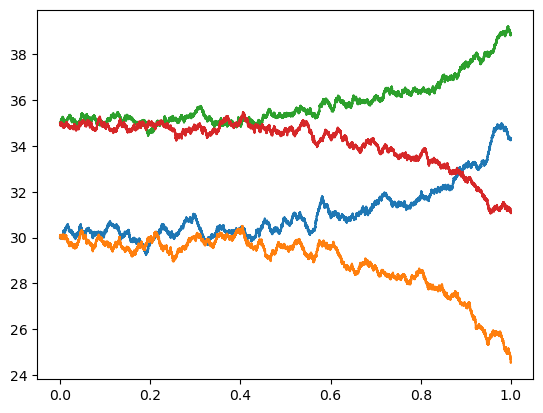

In [19]:
plt.plot(timeVec,Rates[0,:])
plt.plot(timeVec,Rates[1,:])
plt.plot(timeVec,Rates[2,:])
plt.plot(timeVec,Rates[3,:])